In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.draw import disk
from skimage.morphology import skeletonize


import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [86]:
def detect_soma_center(image):
    """
    Automatically detects the soma center in a neuron image by identifying the brightest spot,
    which is typically the soma.

    Args:
        image (numpy.ndarray): Grayscale image of the neuron.

    Returns:
        tuple: (x, y) coordinates of the identified soma center.
    """
    # Find the brightest pixel in the image (typically the soma center)
    _, _, _, brightest_location = cv2.minMaxLoc(image)

    # Create a mask around the brightest point (soma) with a radius of 20 pixels
    soma_mask = np.zeros(image.shape, dtype=np.uint8)
    cv2.circle(soma_mask, brightest_location, 20, 255, -1)  # Circle radius set to 20 pixels

    # Calculate the centroid (center of mass) of the soma mask to get a precise soma location
    moments = cv2.moments(soma_mask)
    soma_x = int(moments['m10'] / moments['m00'])
    soma_y = int(moments['m01'] / moments['m00'])

    return soma_x, soma_y

def get_soma_center(image, method='auto', manual_coords=None):
    """
    Get the soma center based on the specified method (automatic or manual).

    Args:
        image (numpy.ndarray): Grayscale image of the neuron.
        method (str): "auto" for automatic detection, "manual" for user-provided coordinates.
        manual_coords (tuple): Coordinates (x, y) for manual selection. Only required if method is 'manual'.

    Returns:
        tuple: (x, y) coordinates of the soma center.

    Raises:
        ValueError: If an invalid method is provided or invalid manual coordinates are given.
    """
    if method == 'auto':
        # Automatically detect soma center
        return detect_soma_center(image)

    if method == 'manual':
        # Validate manual coordinates
        if manual_coords is None or not isinstance(manual_coords, tuple) or len(manual_coords) != 2:
            raise ValueError("Manual coordinates must be a tuple of the form (x, y).")
        return manual_coords

    raise ValueError("Invalid soma detection method. Choose 'auto' or 'manual'.")



In [87]:
def load_and_process_image(image_path):
    """
    Load and preprocess the image by converting it to grayscale, thresholding it,
    and skeletonizing the image to highlight neuron structures.

    Args:
        image_path (str): Path to the image file.

    Returns:
        tuple: Grayscale image, binary thresholded image, and skeletonized image.
    """
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")

    # Apply Otsu's thresholding to create a binary image
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Perform skeletonization on the binary image to reduce neuron structures to thin lines
    skeletonized_image = skeletonize(binary_image // 255)

    return image, binary_image, skeletonized_image



# Load and preprocess the image
image_path = "neuron.png"  # Replace with your image path
neuron_image, binary_image, skeletonized_image = load_and_process_image(image_path)

# Choose soma detection method: 'auto' or 'manual'
soma_detection_method = 'manual'  # Use 'auto' for automatic detection
manual_soma_coordinates = (305, 550)  # Example coordinates for manual selection
soma_coordinates = get_soma_center(neuron_image, soma_detection_method, manual_coords=manual_soma_coordinates)



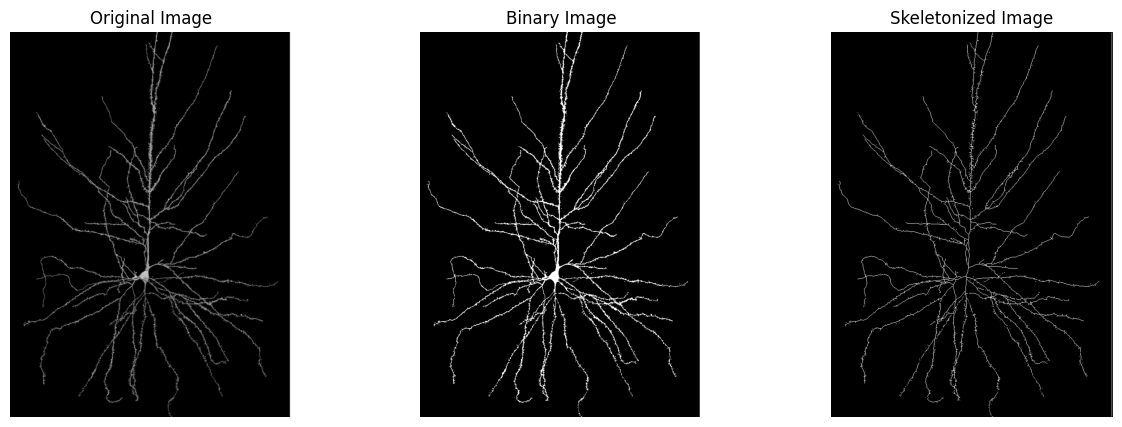

In [88]:
def plot_images(images, titles):
    """
    Plot multiple images in a single row with corresponding titles.

    Args:
        images (list of numpy.ndarray): List of images to display.
        titles (list of str): List of titles corresponding to each image.
    """
    # Create a figure to display the images
    plt.figure(figsize=(15, 5))

    # Plot each image with its corresponding title
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')

    # Show the plot
    plt.show()

plot_images([neuron_image, binary_image, skeletonized_image],
            ['Original Image', 'Binary Image', 'Skeletonized Image'])

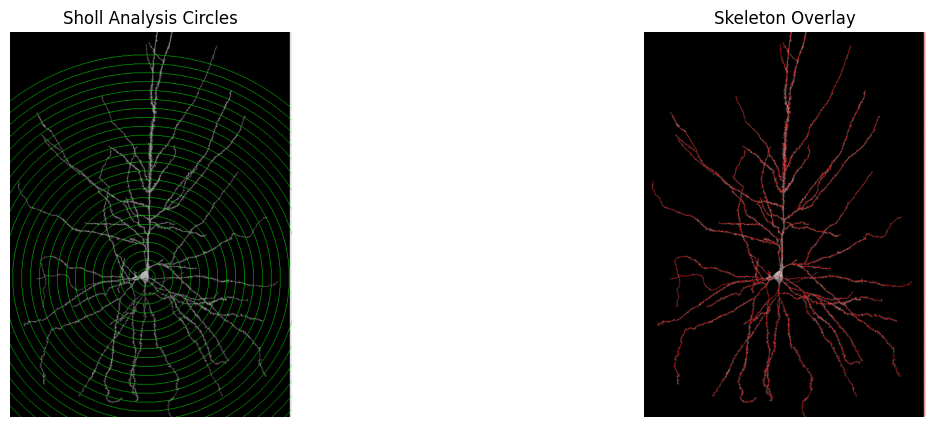

In [89]:
def perform_sholl_analysis(image, skeleton, soma_center, radius_step=20):
    """
    Perform Sholl analysis on the neuron image, counting intersections with concentric circles.

    Args:
        image (numpy.ndarray): Grayscale image of the neuron.
        skeleton (numpy.ndarray): Skeletonized version of the neuron image.
        soma_center (tuple): Coordinates of the soma center (x, y).
        radius_step (int): Distance between concentric circles for Sholl analysis.

    Returns:
        list: Intersection counts for each radius.
        numpy.ndarray: Image with Sholl analysis circles.
    """
    max_radius = int(max(image.shape) * 0.6)
    radii = np.arange(radius_step, max_radius, radius_step)
    intersection_counts = []

    # Create a color image for visualization
    img_with_circles = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for radius in radii:
        rr, cc = disk(soma_center, radius, shape=image.shape)
        circle_mask = np.zeros_like(skeleton, dtype=bool)
        circle_mask[rr, cc] = 1

        # Count intersections
        intersection = np.logical_and(skeleton, circle_mask)
        intersection_counts.append(np.count_nonzero(intersection))

        # Draw the circle on the image for visualization
        cv2.circle(img_with_circles, soma_center, radius, (0, 255, 0), 1)

    return radii, intersection_counts, img_with_circles



# Perform Sholl analysis
radii, intersection_counts, img_with_circles = perform_sholl_analysis(neuron_image, skeletonized_image, soma_coordinates)

# Overlay skeleton on original image for visualization
img_with_skeleton_overlay = cv2.cvtColor(neuron_image, cv2.COLOR_GRAY2BGR)
img_with_skeleton_overlay[skeletonized_image == 1] = [255, 0, 0]  # Red for skeleton

# Visualization of results
plot_images([ img_with_circles, img_with_skeleton_overlay],
            ['Sholl Analysis Circles', 'Skeleton Overlay'])



In [90]:

def polynomial_fit(radii, intersection_counts, degree=3):
    """
    Fit a polynomial to the Sholl analysis data using curve fitting.

    Args:
        radii (numpy.ndarray): Radius values for the Sholl analysis.
        intersection_counts (numpy.ndarray): Number of intersections at each radius.
        degree (int): Degree of the polynomial to fit.

    Returns:
        tuple: Fitted polynomial coefficients, covariance of the fit, R-squared value.
    """
    # Fit the polynomial to the data
    initial_guess = [1] * (degree + 1)  # Initial guess for the coefficients
    popt, pcov = optimize.curve_fit(linear_fit, radii, intersection_counts, p0=initial_guess)

    # Calculate R-squared
    residuals = intersection_counts - linear_fit(radii, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((intersection_counts - np.mean(intersection_counts))**2)
    r_squared = 1 - (ss_res / ss_tot)

    return popt, pcov, r_squared


def linear_fit(radii, *params):
    """
    Polynomial function for fitting.

    Args:
        radii (numpy.ndarray): The radius values.
        *params (float): Polynomial coefficients.

    Returns:
        numpy.ndarray: Polynomial values at the given radii.
    """
    return sum(param * radii**i for i, param in enumerate(params))


def print_fit_details(popt, pcov, r_squared, degree):
    """
    Print the details of the polynomial fit, including coefficients and R-squared value.

    Args:
        popt (numpy.ndarray): Optimized polynomial coefficients.
        pcov (numpy.ndarray): Covariance matrix of the fitted coefficients.
        r_squared (float): R-squared value of the fit.
        degree (int): Degree of the polynomial fit.
    """
    print("Fit Details for Linear Sholl Profile:")
    print(f"Degree of polynomial: {degree}")

    # Print the coefficients and their standard errors
    perr = np.sqrt(np.diag(pcov))  # Standard errors of the parameters
    for i, (param, err) in enumerate(zip(popt, perr)):
        print(f"  a{i} = {param:.4e} ± {err:.4e}")

    print(f"R-squared: {r_squared:.4f}")



# Example usage of the refactored code
degree = 3  # Degree of polynomial fit
popt, pcov, r_squared = polynomial_fit(radii, intersection_counts, degree)

# Print fit details
print_fit_details(popt, pcov, r_squared, degree)


Fit Details for Linear Sholl Profile:
Degree of polynomial: 3
  a0 = 6.7920e+02 ± 2.1990e+02
  a1 = -2.0762e+01 ± 3.5907e+00
  a2 = 1.5696e-01 ± 1.5880e-02
  a3 = -1.5228e-04 ± 2.0099e-05
R-squared: 0.9964


AIC: 276.5650
BIC: 281.4405


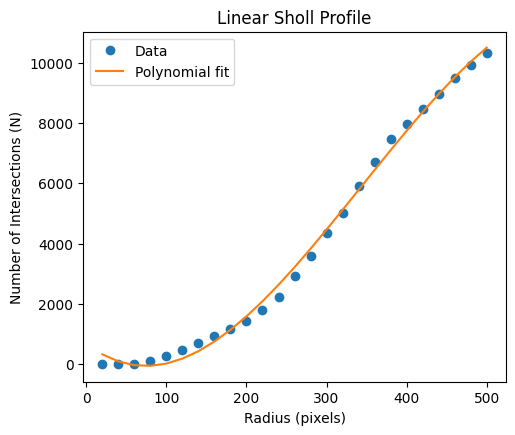

In [91]:
def calculate_aic_bic(residuals, n, k):
    """
    Calculate the AIC and BIC for model evaluation.

    Args:
        residuals (numpy.ndarray): Residuals from the polynomial fit.
        n (int): Number of data points.
        k (int): Number of model parameters (polynomial coefficients).

    Returns:
        tuple: AIC and BIC values.
    """
    ss_res = np.sum(residuals**2)
    aic = 2 * k + n * np.log(ss_res / n)
    bic = np.log(n) * k + n * np.log(ss_res / n)
    return aic, bic


def plot_fit_result(radii, intersection_counts, popt):
    """
    Plot the data and polynomial fit.

    Args:
        radii (numpy.ndarray): Radius values.
        intersection_counts (numpy.ndarray): Intersection counts at each radius.
        popt (numpy.ndarray): Fitted polynomial coefficients.
    """
    plt.figure(figsize=(12, 10))
    plt.subplot(2, 2, 1)
    plt.plot(radii, intersection_counts, 'o', label='Data')
    plt.plot(radii, linear_fit(radii, *popt), '-', label='Polynomial fit')
    plt.title("Linear Sholl Profile")
    plt.xlabel("Radius (pixels)")
    plt.ylabel("Number of Intersections (N)")
    plt.legend()



# Calculate AIC and BIC
n = len(radii)
k = len(popt)
residuals = intersection_counts - linear_fit(radii, *popt)
aic, bic = calculate_aic_bic(residuals, n, k)

print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

# Plot the fitting result
plot_fit_result(radii, intersection_counts, popt)
plt.show()

